In [8]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
from scipy.stats import boxcox
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas import DataFrame
from pandas import Grouper
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from collections import Counter
sns.set_style('darkgrid')
# from dataprep.eda import plot, plot_correlation, plot_missing, create_report
import plotly.express as px
from plotly.offline import plot as off
import plotly.figure_factory as ff
import plotly.io as pio
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, scale
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, \
                                    train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [9]:
# tỉ lệ 9:1
df = pd.read_csv('DXG Historical Data 1_6.csv')
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df['Price'].str.replace(',', '')
# Chuyển sang dạng số
df = pd.to_numeric(df)
df = df[::-1]

df = df.reset_index(drop=True) # Reset the index

In [10]:
scaler = StandardScaler()
df1 = scaler.fit_transform(np.array(df).reshape(-1, 1))


In [11]:
# Assuming df is your DataFrame containing your data
train_size = int(0.9 * len(df))

# Split the data into training and testing sets
train_data = df1[:train_size]
test_data = df1[train_size:]



In [12]:
train_data
test_data.shape

(160, 1)

In [13]:
# !pip install tbats

In [14]:
from tbats import BATS, TBATS
# 3. Quá trình Training
y_train = np.array(train_data)

estimator = TBATS(
    seasonal_periods=[12, 30.25],
    use_arma_errors=True,
    use_box_cox=True
)
model = estimator.fit(y_train)


In [15]:
# 4. Quá trình testing
y_test = np.array(test_data)
y_pred =  model.forecast(steps=190)

In [16]:
print(y_pred[-30:])

[-0.33503472 -0.33134754 -0.31536607 -0.30772774 -0.31531442 -0.33067492
 -0.35174443 -0.37383539 -0.37984661 -0.36597749 -0.35613289 -0.36315139
 -0.36161687 -0.33161506 -0.30257105 -0.31500383 -0.36048879 -0.39808176
 -0.41119759 -0.4107182  -0.40027918 -0.37760217 -0.35644972 -0.35156651
 -0.35313443 -0.34517338 -0.33389074 -0.33093041 -0.32861441 -0.31989621]


In [17]:

y_next_30_days = y_pred[-30:]
y_pred = y_pred[:160]
print(y_pred)
print(y_next_30_days)

[-0.26127659 -0.25091365 -0.23505223 -0.23890482 -0.25471028 -0.25575675
 -0.24172585 -0.23353271 -0.23657248 -0.24210687 -0.25103291 -0.26602121
 -0.27584097 -0.27539204 -0.28212559 -0.30510846 -0.32106429 -0.31115342
 -0.29601684 -0.30054505 -0.30971673 -0.29782128 -0.27885205 -0.28676017
 -0.32227494 -0.35727538 -0.37729689 -0.38505377 -0.37726643 -0.35229024
 -0.32738735 -0.31838475 -0.31682318 -0.31245365 -0.31654284 -0.33506974
 -0.34455108 -0.32744391 -0.30673856 -0.30992104 -0.3224858  -0.31531839
 -0.29662843 -0.29658833 -0.31742884 -0.33711271 -0.34831669 -0.35852659
 -0.36469955 -0.35973468 -0.35074686 -0.34396909 -0.32984424 -0.30925814
 -0.31030103 -0.34783793 -0.39060578 -0.40204616 -0.39040453 -0.38390277
 -0.38101954 -0.364511   -0.34339748 -0.33950941 -0.34722329 -0.34420665
 -0.32967417 -0.319237   -0.31552927 -0.31361111 -0.31925065 -0.33371269
 -0.33969222 -0.33024065 -0.32885495 -0.35105172 -0.37145766 -0.36280422
 -0.34217216 -0.34090799 -0.35177505 -0.34653049 -0

In [18]:
train_data = df[:train_size]
test_data = df[train_size:]
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_next_30_days = scaler.inverse_transform(y_next_30_days.reshape(-1, 1))


In [19]:
test_mae = mean_absolute_error(test_data, y_pred)
test_mape = mean_absolute_percentage_error(test_data, y_pred)
test_rmse = sqrt(mean_squared_error(test_data, y_pred))

print('MAE:', test_mae)
print('RMSE:', test_rmse)
print('MAPE:', test_mape)


MAE: 2968.839776454448
RMSE: 3259.9423007370556
MAPE: 0.1587921806561495


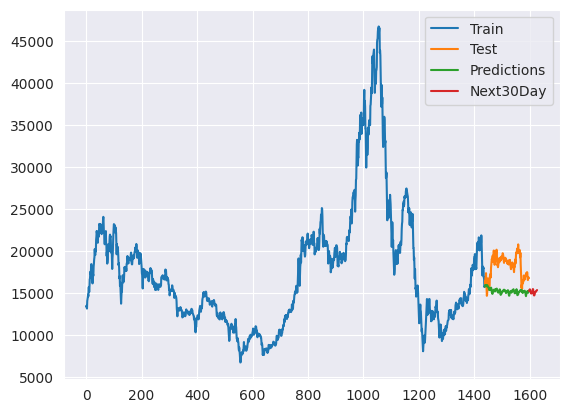

In [20]:
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

plt.plot(train_data.index, train_data)
plt.plot(test_data.index, test_data)
plt.plot(test_data.index, y_pred)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day'])
plt.show()